TODO:
* experiment with narrower sampling of thetas / less trials / fixed presentation time
* analysis with train set / test set

In [1]:
%run experiment1.ipynb

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

numpy       : 2.2.4
MotionClouds: unknown
manim       : 0.19.0
pandas      : 2.2.3
matplotlib  : 3.10.1
scipy       : 1.15.2

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local



## one logistic regression per B_theta for all sessions

Some inductive biases:

* the lapse rate is independent of `B_theta`
* the slope is parameterized for each `B_theta` and should decrease with it

In [2]:
theta_trials = np.array(parameters['theta'])*180/np.pi
theta_max = theta_trials.max()
i_B_theta_trials = np.array(parameters['i_B_theta'])
B_thetas = np.sort(np.array(parameters['B_theta'].unique()))*180/np.pi
# B_thetas, len(B_thetas)

In [3]:
all_responses = np.empty((0, 4))
for i_session, session in enumerate(responses.keys()):
    response_ =  np.vstack((theta_trials, i_B_theta_trials, i_session*np.ones_like(responses[session]), responses[session])).T
    all_responses = np.vstack((all_responses, response_))
all_responses = torch.tensor(all_responses)
all_responses.shape, response_.shape, len(responses)

(torch.Size([6912, 4]), (216, 4), 32)

In [12]:
# Best params: {'batch_size': 25, 'optimizer': 'adamw', 'etab1': 0.026112041005658483, 'etab2': 1.636899979137844e-05, 'learning_rate': 0.005097928784245699, 'amsgrad': False, 'logit0': -1.9248440675525251, 'log_wt': 1.349785497622056}
# Best value: 0.543 at 2025-03-19 08:48:22

# Best params: {'batch_size': 56, 'optimizer': 'adamw', 'weight_decay': 0.0002997092498018415, 'etab1': 0.03345169915953846, 'etab2': 1.9293008255078902e-05, 'learning_rate': 0.005454728541341465, 'amsgrad': False, 'logit0': -2.9675136149215455, 'log_wt': 3.3909176373251846}
# Best value: 0.544 at 2025-03-19 16:49:15

# -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
# Best params: {'batch_size': 42, 'optimizer': 'adamw', 'amsgrad': False, 'weight_decay': 0.0007222860872734696, 'learning_rate': 0.0018338060732716677, 'etab1': 0.00987978899036247, 'etab2': 6.153261356256708e-05, 'logit0': -3.7910022129610472, 'log_wt': 4.253847978522847}
# Best value: 0.543 at 2025-03-19 19:23:31
# --------------------------------------------------

# Best params: {'batch_size': 8, 'optimizer': 'adamw', 'amsgrad': False, 'frozen_theta0': False, 'weight_decay': 0.00011951314778564915, 'learning_rate': 0.0007833543662568058, 'etab1': 0.16642313359618802, 'etab2': 6.879001985087895e-05, 'logit0': -4.342444951035153, 'log_wt': 3.1916632224770405}
# Best value: 0.543 at 2025-03-21 08:46:16

num_epochs = 2 ** 10 + 1
optimizer = 'adamw'
learning_rate = 0.0008
etab1, etab2 = 0.15, 8e-5
weight_decay = 1e-4
batch_size = 8
amsgrad = False
logit0 = -4.
log_wt = 3.2
theta0 = 0.
frozen_theta0 = True

In [ ]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0=logit0, theta0=theta0, log_wt=log_wt, frozen_theta0=False):
        super(LogisticRegressionModel, self).__init__()
        # self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        self.theta0 = torch.nn.Parameter(torch.tensor(theta0))
        if frozen_theta0: self.theta0.requires_grad = False
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(len(responses)).clone().detach())
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(len(B_thetas)).clone().detach())
        self.eps = 1 / 10000

    def forward(self, theta, i_B_theta, i_session):
        p0 = self.logit0[i_session].sigmoid() + self.eps
        theta_slope = torch.exp(self.log_wt[i_B_theta])
        p = torch.sigmoid((theta-self.theta0) / theta_slope)
        output = p0 / 2. + (1. - p0) * p
        return output
    
def fit_data(
    all_responses,
    logit0=logit0, theta0=theta0, log_wt=log_wt, 
    learning_rate=learning_rate,
    batch_size=batch_size,  
    amsgrad=amsgrad, optimizer=optimizer, frozen_theta0=frozen_theta0,
    num_epochs=num_epochs,
    etab1=etab2, etab2=etab2, weight_decay=weight_decay,
    verbose=False
):

    all_theta, all_i_B_theta, all_i_session, all_labels = all_responses[:, 0][:, None], all_responses[:, 1][:, None].long(), all_responses[:, 2][:, None].long(), all_responses[:, 3][:, None]

    loader = DataLoader(
        TensorDataset(all_theta, all_i_B_theta, all_i_session, all_labels), batch_size=batch_size, shuffle=True
    )

    total_loss = torch.log(torch.tensor(2)) # criterion(outputs, labels_)
        
    logistic_model = LogisticRegressionModel(logit0=logit0, log_wt=log_wt, theta0=theta0, frozen_theta0=frozen_theta0)
    logistic_model = logistic_model.to(device)
    logistic_model.train()

    optimizer_dict = dict(lr=learning_rate, weight_decay=weight_decay, betas=(1-etab1, 1-etab2), amsgrad=amsgrad)
    if optimizer=='adam': 
        optimizer = torch.optim.Adam(logistic_model.parameters(), **optimizer_dict)
    elif optimizer=='adamw': 
        optimizer = torch.optim.AdamW(logistic_model.parameters(), **optimizer_dict)    

    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for theta_, i_B_theta_, i_session_, labels_ in loader:
            theta_, i_B_theta_, i_session_, labels_ = theta_.to(device), i_B_theta_.to(device), i_session_.to(device), labels_.to(device)

            # print(theta_, i_B_theta_, torch.sigmoid(logistic_model.logit0[0]).item())
            outputs_ = logistic_model(theta_, i_B_theta_, i_session_)
            # print(outputs_, labels_)
            # print(outputs_, torch.sigmoid(logistic_model.logit0[0]).item())
            # print(torch.sigmoid(logistic_model.logit0.min()).item(), ' - ', torch.sigmoid(logistic_model.logit0.max()).item())
            loss = criterion(outputs_, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.3e}")
            # print(f"Iteration: {epoch} - Evidence: {-np.mean(losses):.3e}")

    logistic_model.eval()
    outputs = logistic_model(all_responses[:, 0][:, None], all_responses[:, 1][:, None].long(), all_responses[:, 2][:, None].long())
    loss = criterion(outputs, all_responses[:, 3][:, None]).item()
    # loss = - logistic_model.evidence(outputs, labels).item()
    return logistic_model, loss / total_loss


In [14]:
# for the plot
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]
# Create a colormap
# cmap = plt.get_cmap('viridis')
import cmocean
# cmap = cmocean.cm.phase
cmap = cmocean.cm.solar_r
norm = plt.Normalize(vmin=0, vmax=len(B_thetas) - 1)


frozen_theta0=False
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*
Loss = 5.432e-01 - theta0 = -0.34°, p0 = 2.42e-02, slope = 1.79e+01


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_62162/2747127532.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10, frameon=False, scatterpoints=6);


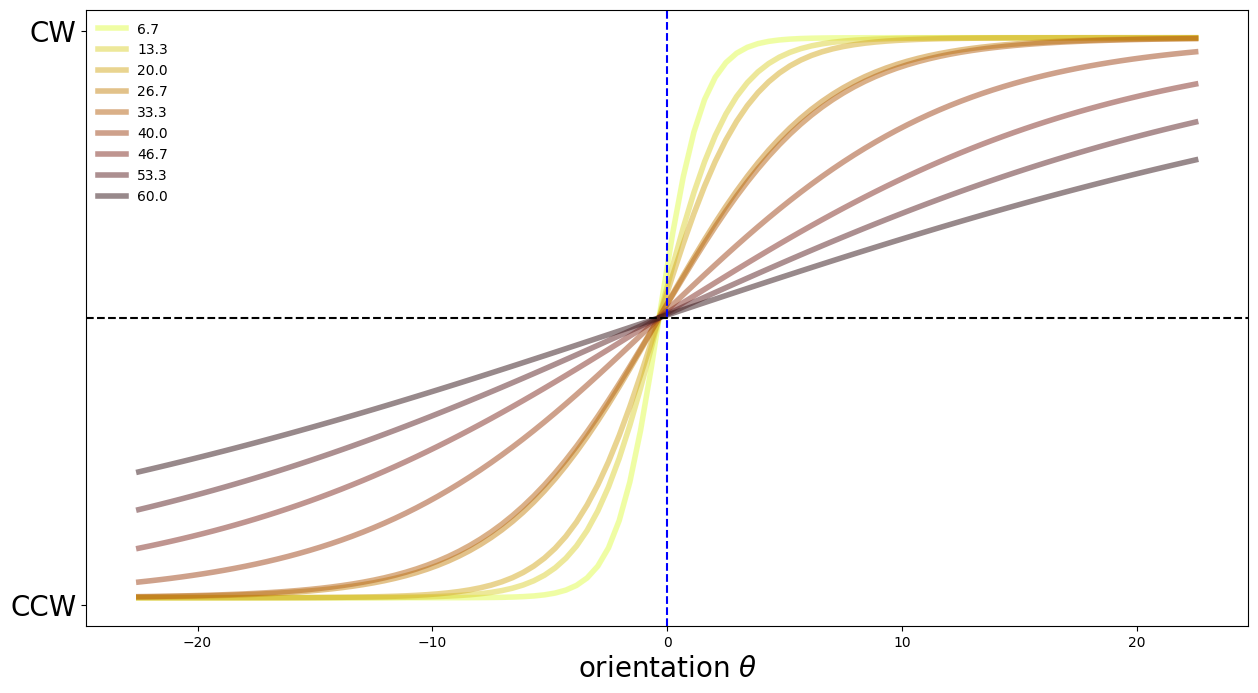

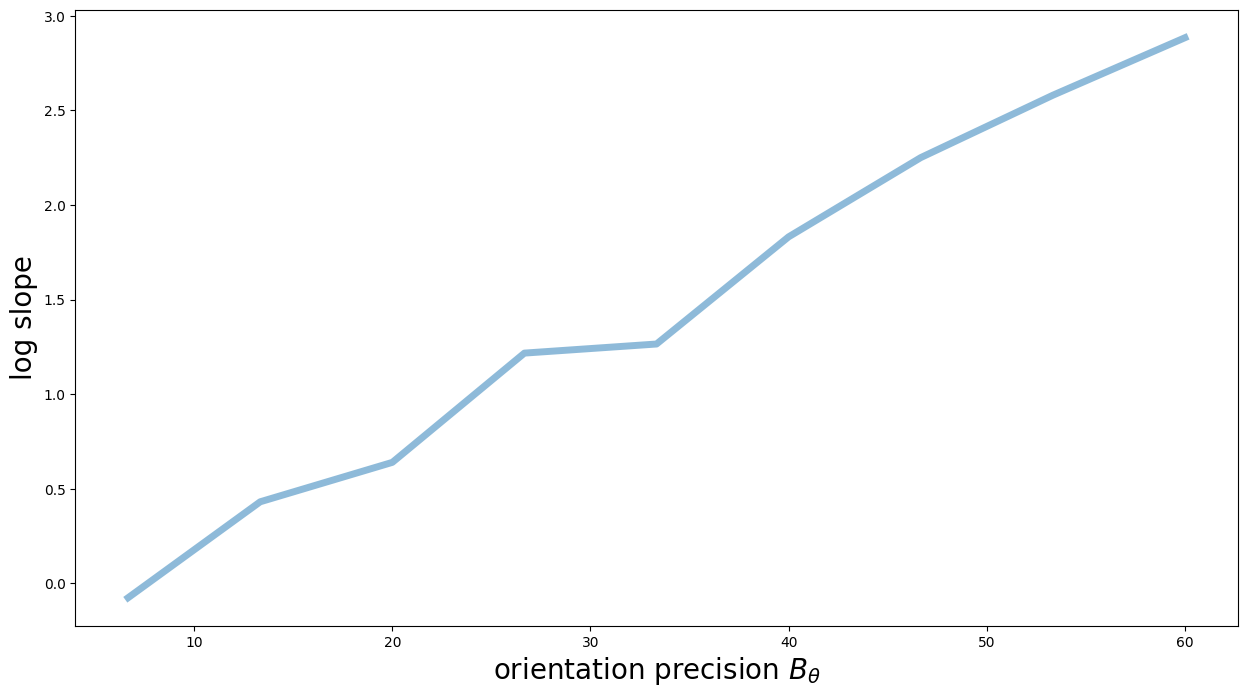

frozen_theta0=True
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*
Loss = 5.436e-01 - theta0 = 0.00°, p0 = 2.47e-02, slope = 1.77e+01


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_62162/2747127532.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10, frameon=False, scatterpoints=6);


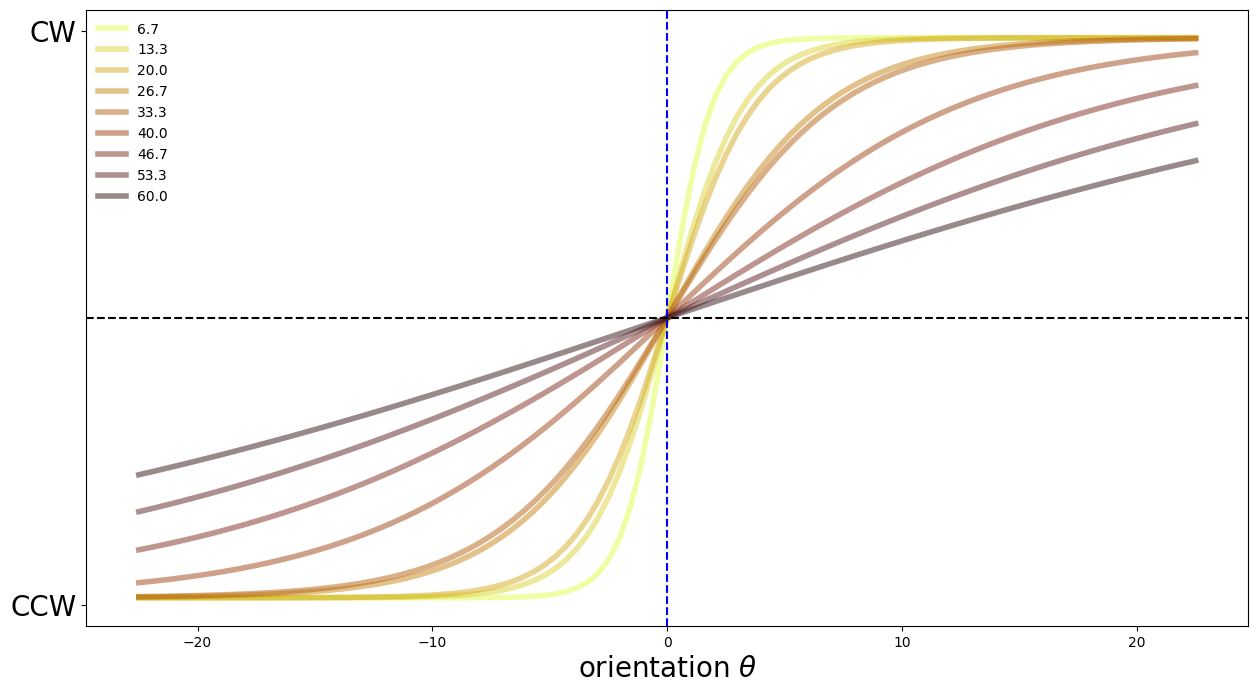

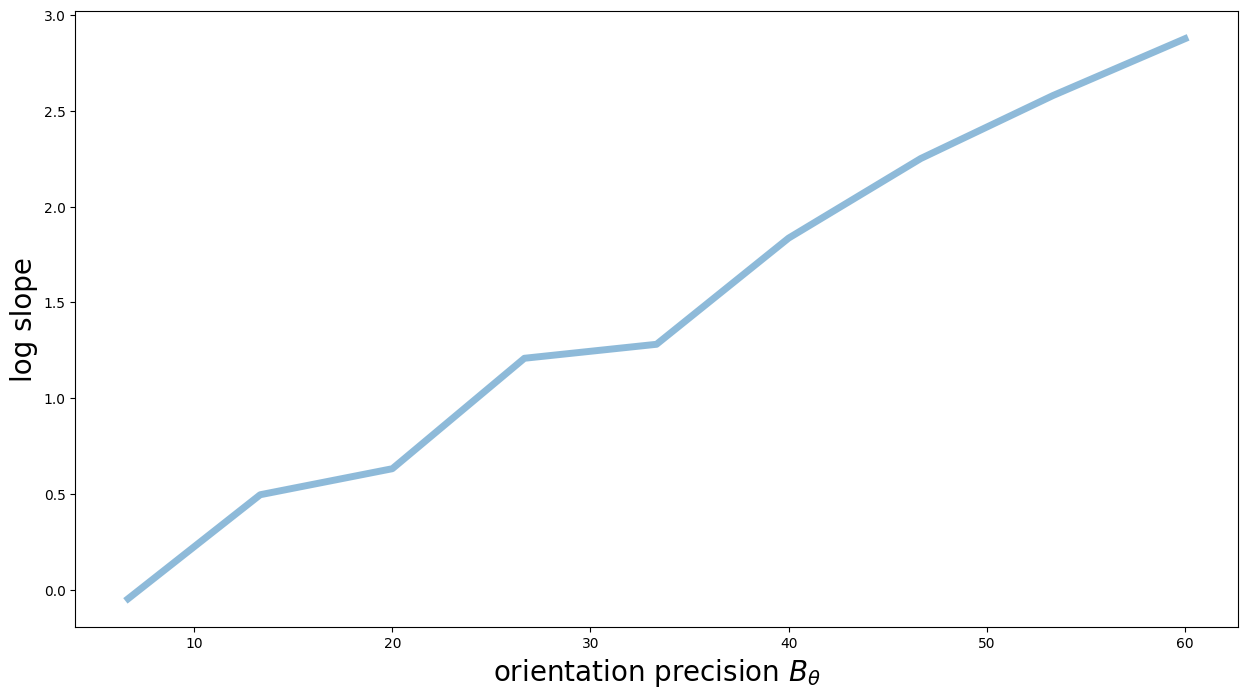

In [15]:

for frozen_theta0 in [False, True]:

    print(f'{frozen_theta0=}')
    print(50*'.-*')
    
    fig, ax = plt.subplots(figsize=(15, 8))
    fig2, ax2 = plt.subplots(figsize=(15, 8))

    logistic_model, loss = fit_data(all_responses, frozen_theta0=frozen_theta0, verbose=False)
    print(f"Loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.2f}°, p0 = {torch.sigmoid(logistic_model.logit0[0]).item():.2e}, slope = {torch.exp(logistic_model.log_wt[-1]).item():.2e}")

    for i_B_theta, B_theta in enumerate(B_thetas):
        y_values = logistic_model(torch.Tensor(x_values), 
                                  i_B_theta*torch.ones_like(torch.Tensor(x_values)).long(), 
                                  torch.zeros_like(torch.Tensor(x_values)).long()).detach().numpy()
        ax.plot(x_values, y_values, color=cmap(norm(i_B_theta)), alpha=0.5, lw=4, label=f'{B_theta:.1f}')
    ax2.plot(B_thetas, logistic_model.log_wt.detach().numpy(), alpha=0.5, lw=5)
    # print(logistic_model.log_wt.detach().numpy())

    ax.set_xlabel(r"orientation $\theta$", fontsize=20)
    ax.axhline(.5, color='k', linestyle='--')
    ax.axvline(0., color='b', linestyle='--')
    ax.set_yticks([0.0, 1.0])
    ax.set_yticklabels(["CCW", "CW"], fontsize=20)
    ax.legend(fontsize=10, frameon=False, scatterpoints=6);


    ax2.set_xlabel(r"orientation precision $B_\theta$", fontsize=20)
    ax2.set_ylabel(r"log slope", fontsize=20)
    ax2.legend(fontsize=10, frameon=False, scatterpoints=6);

    plt.show();


### optimize learning parameters with optuna

In [8]:
logistic_model, loss = fit_data(all_responses, verbose=True)

Iteration: 0 - Loss: 5.588e-01
Iteration: 32 - Loss: 3.817e-01
Iteration: 64 - Loss: 3.821e-01
Iteration: 96 - Loss: 3.818e-01
Iteration: 128 - Loss: 3.799e-01
Iteration: 160 - Loss: 3.797e-01
Iteration: 192 - Loss: 3.793e-01
Iteration: 224 - Loss: 3.790e-01
Iteration: 256 - Loss: 3.790e-01
Iteration: 288 - Loss: 3.790e-01
Iteration: 320 - Loss: 3.789e-01
Iteration: 352 - Loss: 3.789e-01
Iteration: 384 - Loss: 3.789e-01
Iteration: 416 - Loss: 3.788e-01
Iteration: 448 - Loss: 3.788e-01
Iteration: 480 - Loss: 3.788e-01
Iteration: 512 - Loss: 3.788e-01
Iteration: 544 - Loss: 3.788e-01
Iteration: 576 - Loss: 3.788e-01
Iteration: 608 - Loss: 3.788e-01
Iteration: 640 - Loss: 3.788e-01
Iteration: 672 - Loss: 3.788e-01
Iteration: 704 - Loss: 3.788e-01
Iteration: 736 - Loss: 3.788e-01
Iteration: 768 - Loss: 3.788e-01
Iteration: 800 - Loss: 3.788e-01
Iteration: 832 - Loss: 3.788e-01
Iteration: 864 - Loss: 3.788e-01
Iteration: 896 - Loss: 3.788e-01
Iteration: 928 - Loss: 3.788e-01
Iteration: 960 

In [9]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = 'i_B_theta-sessions'
path_save_optuna = os.path.join('/tmp', f'optuna_{study_name}.sqlite3') # global name
%rm {path_save_optuna}

In [10]:
def objective(trial):
    vars = dict(verbose = False,  num_epochs=num_epochs//2)
    vars['batch_size'] = trial.suggest_int('batch_size', 2, 512, log=True, step=1)
    vars['optimizer'] = trial.suggest_categorical('optimizer', ['adamw', 'adam']) # 'adagrad', 'sparseadam', 'rmsprop', 'adadelta', 'sgd',
    vars['amsgrad'] = trial.suggest_categorical('amsgrad', [True, False])
    vars['frozen_theta0'] = trial.suggest_categorical('frozen_theta0', [True, False])

    max_threshold = .999
    scale = 10
    vars['weight_decay'] = trial.suggest_float('weight_decay', weight_decay / scale, weight_decay * scale, log=True)
    vars['learning_rate'] = trial.suggest_float('learning_rate', learning_rate / scale, learning_rate * scale, log=True)
    vars['etab1'] = trial.suggest_float('etab1', etab1/scale, min(etab1*scale, max_threshold), log=True)
    vars['etab2'] = trial.suggest_float('etab2', etab2/scale, min(etab2*scale, max_threshold), log=True)
    scale = 4
    scale = 2
    # initialization
    vars['logit0'] = trial.suggest_float('logit0', logit0 - scale, logit0 + scale, log=False)
    vars['log_wt'] = trial.suggest_float('log_wt', log_wt - scale, log_wt + scale, log=False)
    # vars['theta0'] = trial.suggest_float('theta0', theta0 - scale, theta0 + scale, log=False)

    loss = 0
    _, loss = fit_data(all_responses, **vars)

    return loss

print(50*'=')
sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
study = optuna.create_study(direction='minimize', load_if_exists=True, sampler=sampler, storage=f"sqlite:///{path_save_optuna}", study_name=study_name)
study.optimize(objective, n_trials=max((500-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)
print(50*'=')

/Users/laurentperrinet/sdrive_cnrs/hot_from_git/OEiL_OrientationPrecision/.venv/lib/python3.13/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
print(50*'-.')
print(f"Best params: {study.best_params}")
print(f"Best value: {study.best_value:.3f} at {now.strftime("%Y-%m-%d %H:%M:%S")}")
print(50*'-')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Best params: {'batch_size': 8, 'optimizer': 'adamw', 'amsgrad': False, 'frozen_theta0': False, 'weight_decay': 0.00011951314778564915, 'learning_rate': 0.0007833543662568058, 'etab1': 0.16642313359618802, 'etab2': 6.879001985087895e-05, 'logit0': -4.342444951035153, 'log_wt': 3.1916632224770405}
Best value: 0.543 at 2025-03-21 08:46:16
--------------------------------------------------
